imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"
experimentName="Fish_scheduler_experiments"#"CIFAR_phylogeny_HGNN_lambdaExperiment"
trial_hash="5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186"#hier

legends=['fine', 'coarse']
use_submodel=True
cuda=1
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 1


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataloader = torch.utils.data.DataLoader(test_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'experimentName': 'Fish_scheduler_experiments', 'modelName': 'models/5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186', 'datasetName': 'datasplits/7c7513bdfb4e5577fef1c3ec0fa6452d30d87dbc95f258a7c86dd76b', 'experimentHash': 'd76671f30f9c5b1773e7c876f09f3c399e6e6f05d785b8dcb5023857', 'trialHash': '5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186', 'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.0, 'unsupervisedOnTest': None, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': True, 'tripletSamples': 2.0, 'tripletSelector': 'semihard', 'tripletMargin': 2.0, 'displayName': 'Fish-s-triplet-hier-gamma0.5', 'pretrained': True, 'epochs': 40.0, 'patience': -1.0, 

Get untrained model

In [5]:
%%capture

architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

100%|██████████| 95/95 [00:11<00:00,  8.28it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.003s...
[t-SNE] Computed neighbors for 380 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 43.325647
[t-SNE] Computed conditional probabilities in 0.024s
[t-SNE] Iteration 50: error = 70.1435318, gradient norm = 0.5487550 (50 iterations in 0.061s)
[t-SNE] Iteration 100: error = 71.0889587, gradient norm = 0.5354585 (50 iterations in 0.187s)
[t-SNE] Iteration 150: error = 69.0396652, gradient norm = 0.5637177 (50 iterations in 0.078s)
[t-SNE] Iteration 200: error = 70.6572952, gradient norm = 0.5518303 (50 iterations in 0.038s)
[t-SNE] Iteration 250: error = 71.0038071, gradient norm = 0.5447854 (50 iterations in 0.044s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.003807
[t-SNE] Iteration 300: error = 0.9201993, gradient norm = 0.0049136 (50 iterations in 0.041s)
[t-SNE] Iteration 350: error = 0.8344496, gradient norm = 0.0009447 

100%|██████████| 95/95 [00:06<00:00, 15.51it/s]


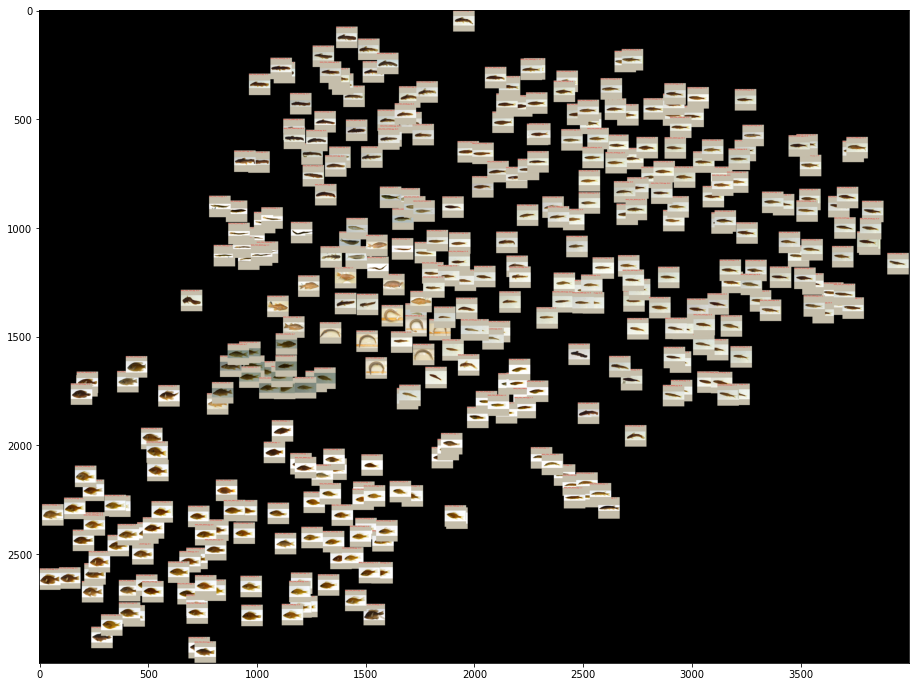

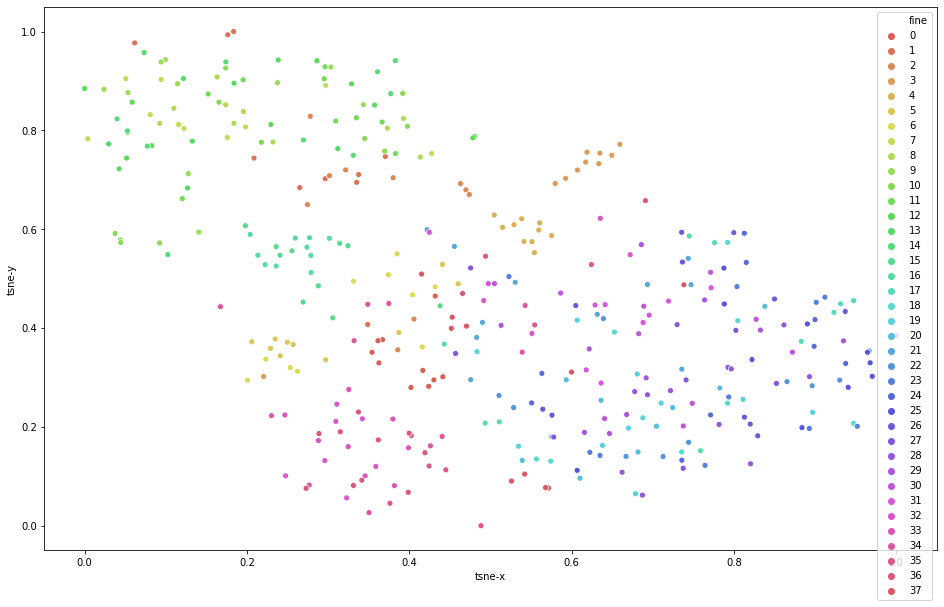

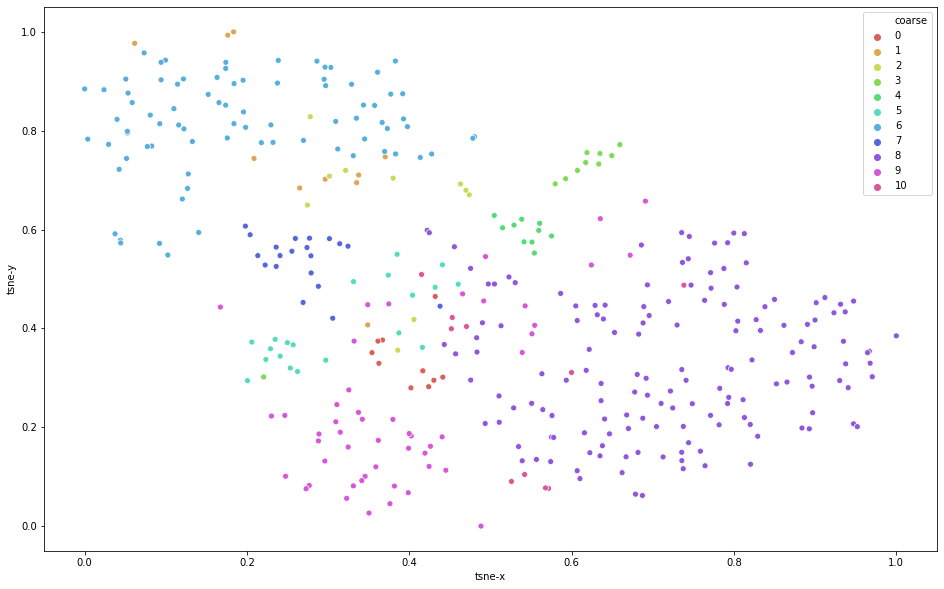

In [6]:
activation_layer = 'layer2'#'fine'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                "test_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 95/95 [00:07<00:00, 13.38it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.003s...
[t-SNE] Computed neighbors for 380 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 107.355003
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 61.3908615, gradient norm = 0.5756692 (50 iterations in 0.246s)
[t-SNE] Iteration 100: error = 60.8012924, gradient norm = 0.6101933 (50 iterations in 0.380s)
[t-SNE] Iteration 150: error = 62.8414917, gradient norm = 0.5684441 (50 iterations in 0.398s)
[t-SNE] Iteration 200: error = 61.8126755, gradient norm = 0.5813792 (50 iterations in 0.198s)
[t-SNE] Iteration 250: error = 62.0945587, gradient norm = 0.5378139 (50 iterations in 0.241s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.094559
[t-SNE] Iteration 300: error = 0.4116781, gradient norm = 0.0043958 (50 iterations in 0.270s)
[t-SNE] Iteration 350: error = 0.3540121, gradient norm = 0.0009026

100%|██████████| 95/95 [00:06<00:00, 14.83it/s]


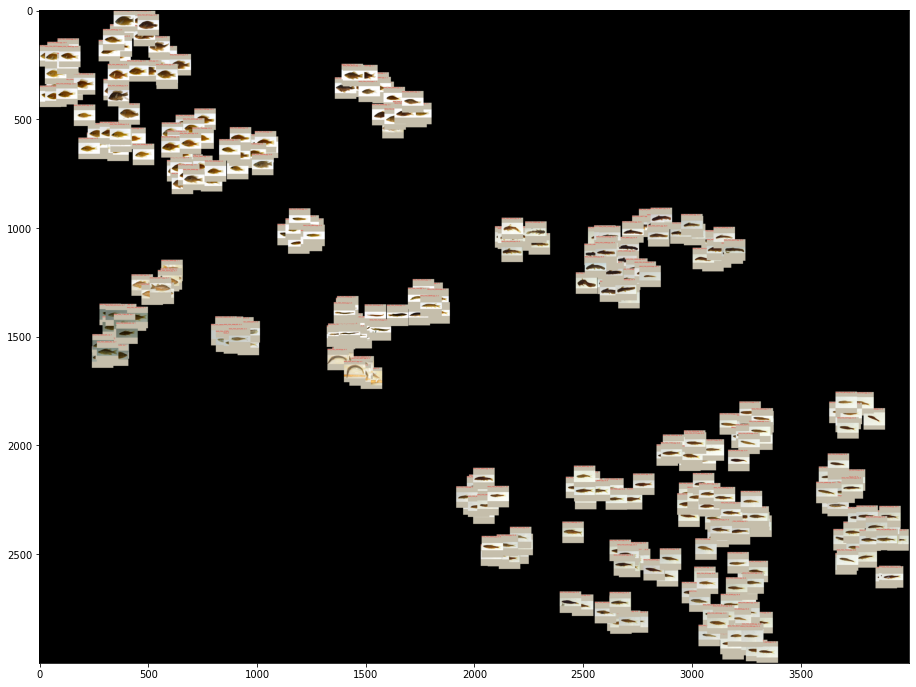

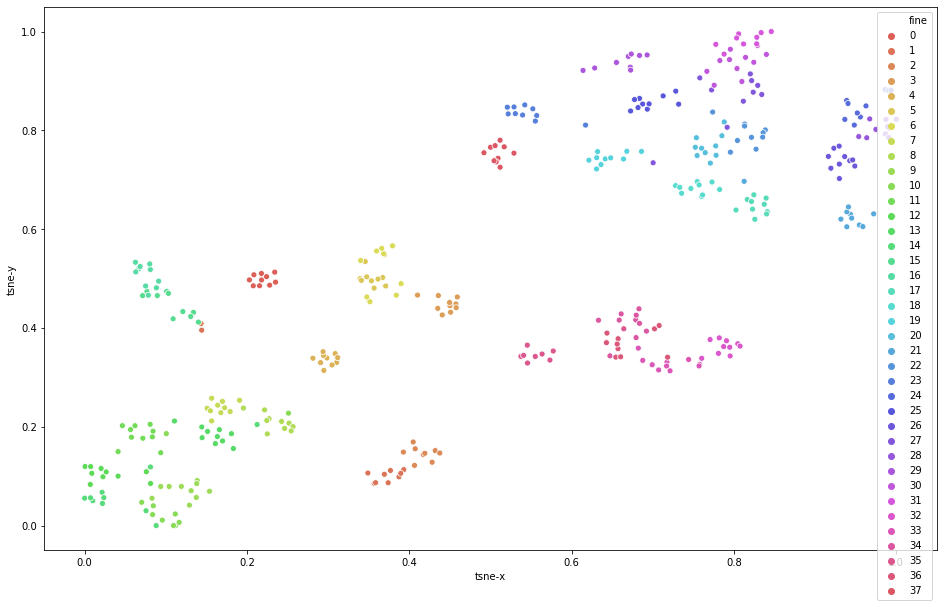

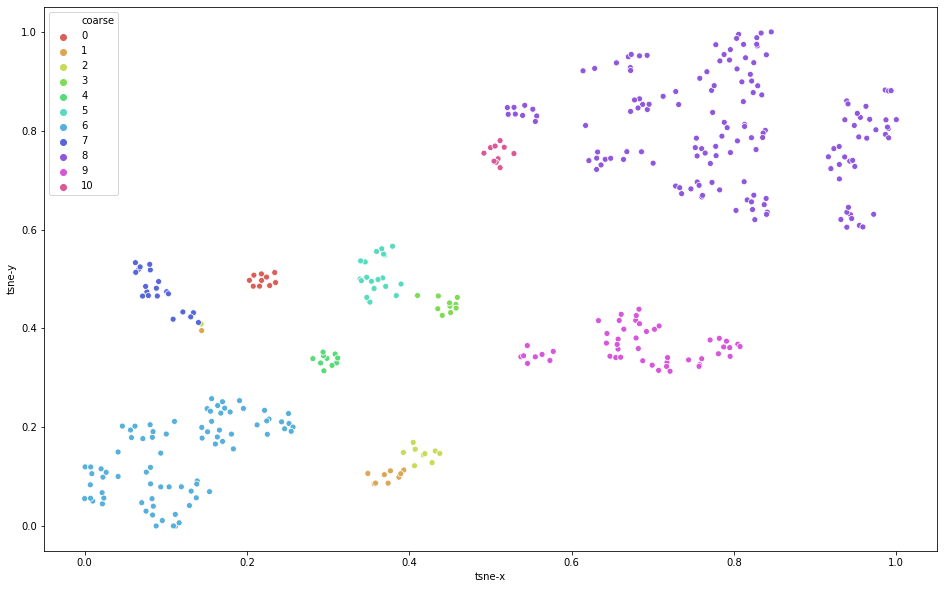

In [7]:
activation_layer = 'layer4'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                "test_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 95/95 [00:07<00:00, 13.47it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.002s...
[t-SNE] Computed neighbors for 380 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 5.041567
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 58.5336189, gradient norm = 0.5486382 (50 iterations in 0.253s)
[t-SNE] Iteration 100: error = 57.5601921, gradient norm = 0.5648593 (50 iterations in 0.171s)
[t-SNE] Iteration 150: error = 57.4741707, gradient norm = 0.5729411 (50 iterations in 0.042s)
[t-SNE] Iteration 200: error = 57.5597153, gradient norm = 0.5564656 (50 iterations in 0.133s)
[t-SNE] Iteration 250: error = 58.0982056, gradient norm = 0.5622897 (50 iterations in 0.123s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.098206
[t-SNE] Iteration 300: error = 0.3125359, gradient norm = 0.0013412 (50 iterations in 0.034s)
[t-SNE] Iteration 350: error = 0.2794273, gradient norm = 0.0004085 (

100%|██████████| 95/95 [00:05<00:00, 16.73it/s]


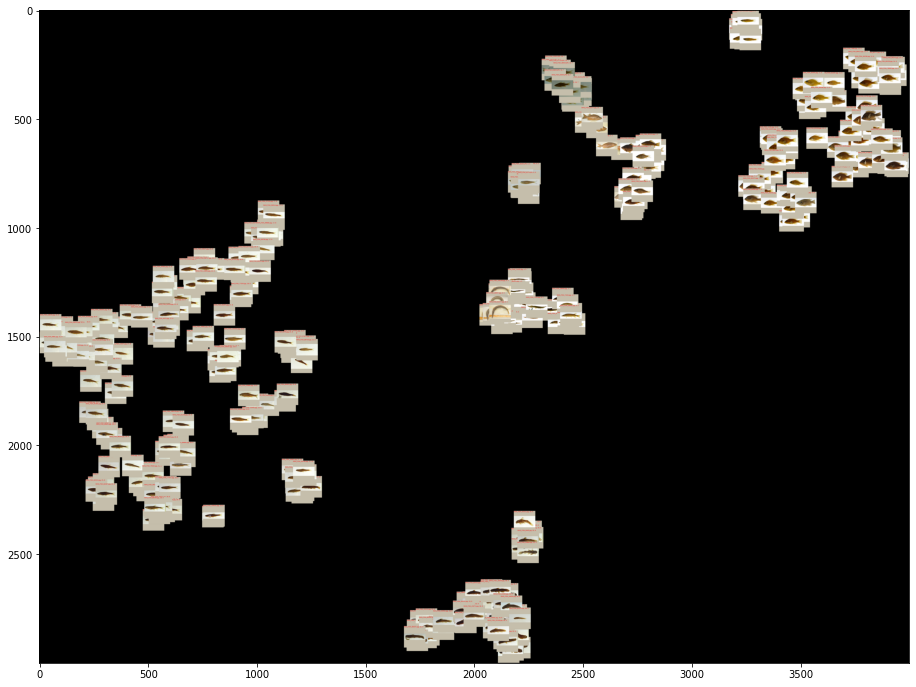

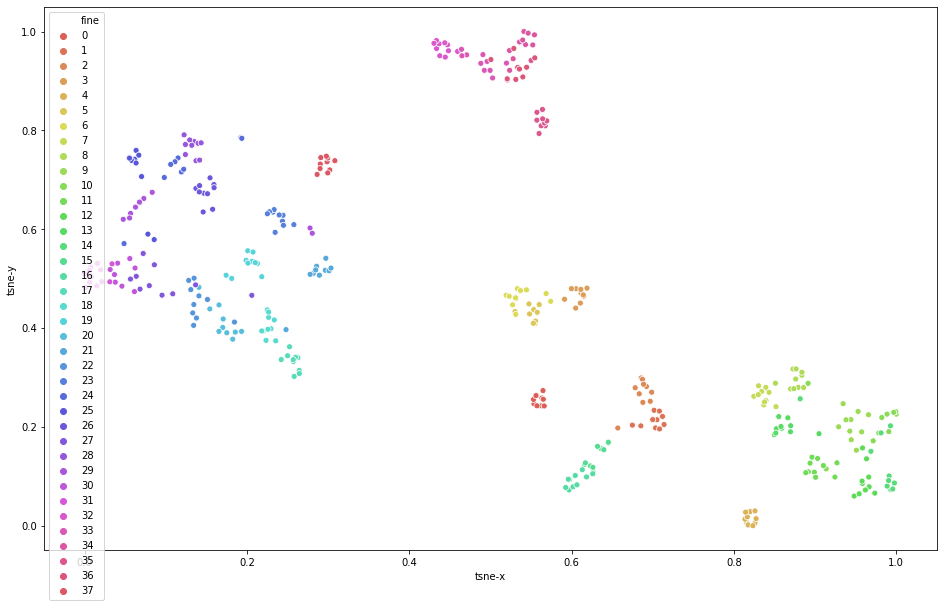

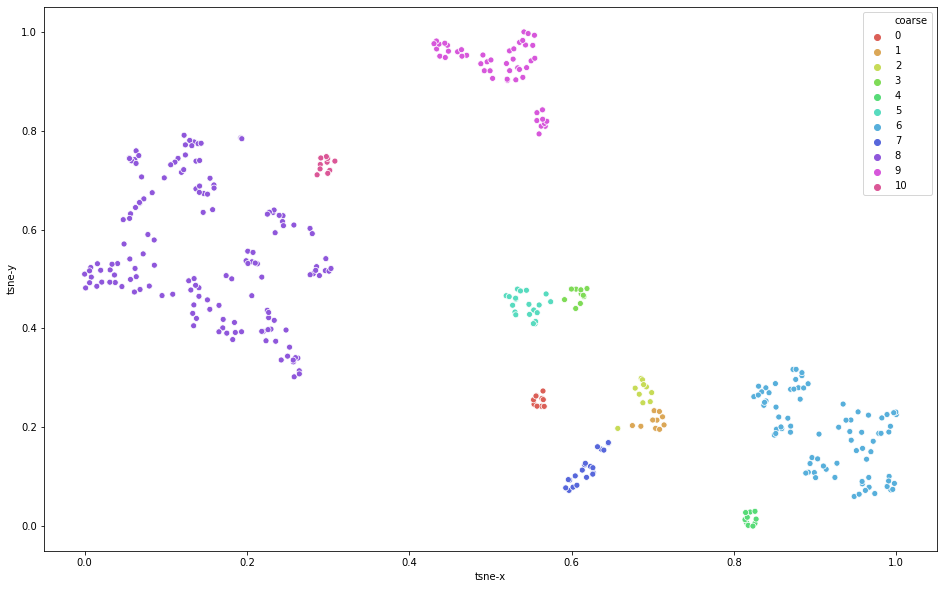

In [8]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                "test_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)